In [1]:
import csv
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.io import loadmat

# DeepMoD stuff
from deepymod import DeepMoD
from deepymod.model.func_approx import NN, Siren
from deepymod.model.library import Library1D
from deepymod.model.constraint import LeastSquares
from deepymod.model.sparse_estimators import Clustering, Threshold
from deepymod.training import train
from deepymod.training.sparsity_scheduler import TrainTestPeriodic
# Setting cuda
#if torch.cuda.is_available():
#    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    
# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
data = loadmat('cable_compare.mat')
usol = np.real(data['Expression1'])
usol= usol.reshape((12,500,3))
x_v= usol[:,:,0]
t_v = usol[:,:,1]
u_v = usol[:,:,2]
u_v_full = u_v
u_v =  np.take(u_v,np.arange(0,u_v.shape[0],1),axis=0)
noise_level = 0.1 
u_v_noise =   u_v + noise_level * np.std(u_v) * np.random.randn(u_v.shape[0],u_v.shape[1])

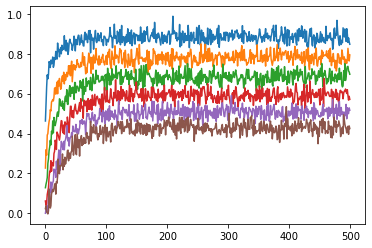

In [3]:
plt.plot(u_v_noise[0,:])
plt.plot(u_v_noise[1,:])
plt.plot(u_v_noise[2,:])
plt.plot(u_v_noise[3,:])
plt.plot(u_v_noise[4,:])
plt.plot(u_v_noise[5,:])

In [4]:
import pysindy as ps
fd_spline = ps.SINDyDerivative(kind='spline', s=1e-2)

In [5]:
x = np.linspace(0, 1, u_v.shape[0])
t = np.linspace(0, 5, u_v.shape[1])

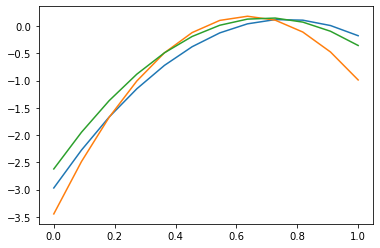

In [6]:
plt.plot(x,fd_spline(u_v_noise[:,5],x))
plt.plot(x,fd_spline(u_v_noise[:,3],x))
plt.plot(x,fd_spline(u_v_noise[:,1],x))

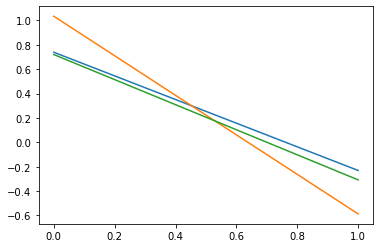

In [7]:
plt.plot(x,fd_spline(fd_spline(u_v_noise[:,5],x)))
plt.plot(x,fd_spline(fd_spline(u_v_noise[:,3],x)))
plt.plot(x,fd_spline(fd_spline(u_v_noise[:,1],x)))

In [9]:
x = np.linspace(0, 1, u_v.shape[0])
t = np.linspace(0, 5, u_v.shape[1])

In [10]:
x_grid, t_grid = np.meshgrid(x, t, indexing='ij')

In [11]:
X = np.transpose((t_grid.flatten(), x_grid.flatten()))
y = np.real(u_v_noise).reshape((u_v_noise.size, 1))
y = y/np.max(y)

In [12]:
number_of_samples = 5000

idx = np.random.permutation(y.shape[0])
X_train = torch.tensor(X[idx, :][:number_of_samples], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y[idx, :][:number_of_samples], dtype=torch.float32)

In [13]:
network = NN(2, [30, 30, 30, 30], 1)

Configuration of the library function: We select athe library with a 2D spatial input. Note that that the max differential order has been pre-determined here out of convinience. So, for poly_order 1 the library contains the following 12 terms:
* [$1, u_x, u_{xx}, u_{xxx}, u, u u_{x}, u u_{xx}, u u_{xxx}, u^2, u^2 u_{x}, u^2 u_{xx}, u^2 u_{xxx}$]

In [14]:
library = Library1D(poly_order=1, diff_order=2) 

Configuration of the sparsity estimator and sparsity scheduler used. In this case we use the most basic threshold-based Lasso estimator and a scheduler that asseses the validation loss after a given patience. If that value is smaller than 1e-5, the algorithm is converged.  

In [15]:
estimator = Threshold(0.025) 
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=10, delta=1e-5) 

Configuration of the sparsity estimator 

In [16]:
constraint = LeastSquares() 
# Configuration of the sparsity scheduler

Now we instantiate the model and select the optimizer 

In [17]:
model = DeepMoD(network, library, estimator, constraint)

In [18]:
# Defining optimizer
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=2e-3) 

## Run DeepMoD 

We can now run DeepMoD using all the options we have set and the training data:
* The directory where the tensorboard file is written (log_dir)
* The ratio of train/test set used (split)
* The maximum number of iterations performed (max_iterations)
* The absolute change in L1 norm considered converged (delta)
* The amount of epochs over which the absolute change in L1 norm is calculated (patience)

In [19]:
train(model, X_train, y_train, optimizer,sparsity_scheduler, log_dir='runs/compare/', split=0.8, max_iterations=100000, delta=1e-7, patience=200) 

 20100  MSE: 1.01e-03  Reg: 1.28e-05  L1: 1.41e+02 

KeyboardInterrupt: 

In [28]:
print(model.estimator_coeffs())

[array([[ 0.       ],
       [ 0.       ],
       [ 1.2211134],
       [-0.5007343],
       [ 0.       ],
       [ 0.       ]], dtype=float32)]


In [29]:
sol = model(torch.tensor(X, dtype=torch.float32))[0].reshape(output_data.shape).detach().numpy()

In [30]:
ux = model(torch.tensor(X, dtype=torch.float32))[2][0][:,1].reshape(output_data.shape).detach().numpy()
uxx = model(torch.tensor(X, dtype=torch.float32))[2][0][:,2].reshape(output_data.shape).detach().numpy()

In [31]:
ut = model(torch.tensor(X, dtype=torch.float32))[1][0].reshape(output_data.shape).detach().numpy()

In [32]:
import pysindy as ps

In [33]:
fd_spline = ps.SINDyDerivative(kind='spline', s=1e-2)
fd_spectral = ps.SINDyDerivative(kind='spectral')
fd_sg = ps.SINDyDerivative(kind='savitzky_golay', left=0.5, right=0.5, order=3)

In [45]:
ground_truth[x0,:].shape

(6,)

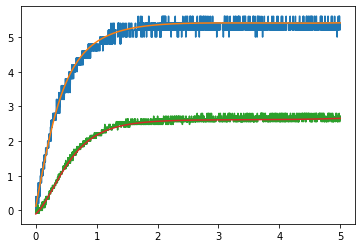

In [58]:
x0 = 2
plt.plot(t,output_data[x0,:])
plt.plot(t,sol[x0,:]*np.max(output_data))

x0 = 4
plt.plot(t,output_data[x0,:])
plt.plot(t,sol[x0,:]*np.max(output_data))

In [61]:
sol[:,t0].shape

(6,)

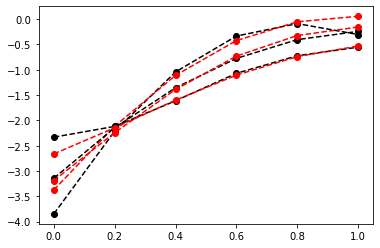

In [74]:
t0 = 50
plt.plot(x,fd_spline(output_data[:,t0]),'ko--')
plt.plot(x,ux[:,t0]*np.max(output_data)/np.max(t),'ro--')

t0 = 100
plt.plot(x,fd_spline(output_data[:,t0]),'ko--')
plt.plot(x,ux[:,t0]*np.max(output_data)/np.max(t),'ro--')

t0 = 200
plt.plot(x,fd_spline(output_data[:,t0]),'ko--')
plt.plot(x,ux[:,t0]*np.max(output_data)/np.max(t),'ro--')

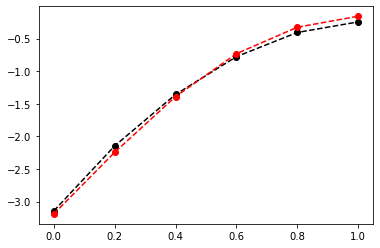

In [75]:
t0 = 100
plt.plot(x,fd_spline(output_data[:,t0]),'ko--')
plt.plot(x,ux[:,t0]*np.max(output_data)/np.max(t),'ro--')

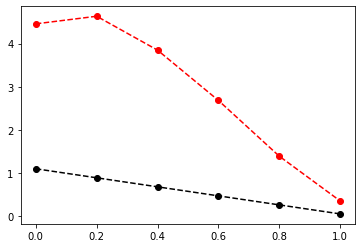

In [79]:
t0 = 100
plt.plot(x,fd_spline(fd_spline(output_data[:,t0])),'ko--')
plt.plot(x,uxx[:,t0]*np.max(output_data)/np.max(t),'ro--')

In [ ]:
t0 = 50
plt.plot(x,output_data[:,t0],'ko--')
plt.plot(x,sol[:,t0]*np.max(output_data),'ro--')

t0 = 100
plt.plot(x,output_data[:,t0],'ko--')
plt.plot(x,sol[:,t0]*np.max(output_data),'ro--')

t0 = 200
plt.plot(x,output_data[:,t0],'ko--')
plt.plot(x,sol[:,t0]*np.max(output_data),'ro--')

In [65]:
t0=100

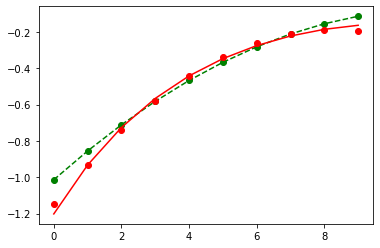

In [66]:
plt.plot(fd_spline(u_v_noise[:,t0],x),'go--')
plt.plot(fd_spline(u_v[:,t0],x),'ro')
plt.plot(ux[:,t0]*np.max(output_data),'r')

In [68]:
np.max(output_data)

1.1172187044526356

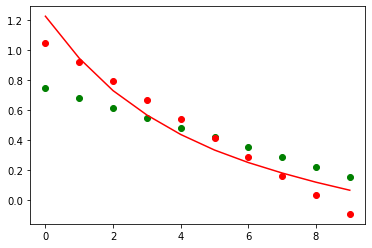

In [70]:
plt.plot(fd_spline(fd_spline(u_v_noise[:,t0],x),x),'go')
plt.plot(fd_spline(fd_spline(u_v[:,t0],x),x),'ro')
plt.plot(uxx[:,t0]*np.max(output_data)*np.max(output_data),'r')